# Cloud Type Classification

Dataset do Kaggle com imagens do céu classificadas em sete categorias distindas, sendo:

Sendo:

* 0 = cirriform clouds;
* 1 =  high cumuliform clouds;
* 2 = stratocumulus clouds;
* 3 = cumulus clouds;
* 4 = cumulonimbus clouds;
* 5 = stratiform clouds;
* 6 = clear sky;


## Organizar a pasta com as imagens de treino

O script abaixo organiza as imagens em subpastas nomeadas de acordo com a label de cada imagem, por exemplo a pasta __'0'__ contém somente imagens da classe __'0'__.

In [96]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

def split_train_test(file_name = 'train.csv'):

    data_csv_path = file_name
    df = pd.read_csv(data_csv_path)
    classes = df['label'].drop_duplicates()


    if os.path.isdir('train_data'): shutil.rmtree('train_data')
    if os.path.isdir('test_data'): shutil.rmtree('test_data')

    for classe in classes:
        os.makedirs(f'train_data/{classe}')
        os.makedirs(f'test_data/{classe}')

    id_train, id_test, label_train, label_test = train_test_split(
        df['id'], df['label'], test_size=0.2, stratify=df['label'], random_state=34
    )
    df = pd.concat([
        pd.DataFrame({'type': 'train', 'id': id_train, 'label': label_train}),
        pd.DataFrame({'type': 'test', 'id': id_test, 'label': label_test}),
    ])
    
    for i, row in df.iterrows():
        path_or = f"images/train/{row['id']}"
        path_dest = f"{row['type']}_data/{row['label']}/{row['id']}"
        shutil.copy(path_or, path_dest)

split_train_test()

Segue um exemplo de cada uma das classes de imagens escolhidas de forma aleatória de cada uma das classes

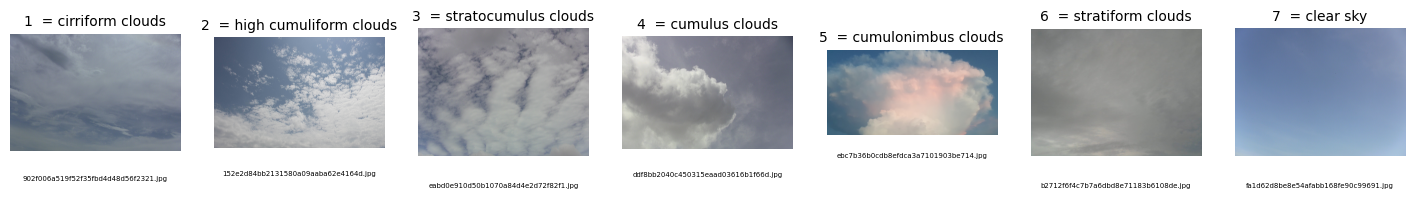

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

fig, axs = plt.subplots(1, 7, figsize=(18, 2))

maping_img = {'0': 'cirriform clouds', '1':  'high cumuliform clouds', '2': 'stratocumulus clouds', '3': 'cumulus clouds', '4': 'cumulonimbus clouds', '5': 'stratiform clouds', '6': 'clear sky'}

train_dir = os.listdir('train_data')
for dir in train_dir:
    file_name = random.choice(os.listdir(f'train_data/{dir}'))
    file_path = f"train_data/{dir}/{file_name}"
    img = mpimg.imread(file_path)
    axs[int(dir)].imshow(img)
    axs[int(dir)].axis('off')
    axs[int(dir)].set_title(f"{int(dir)+1}  = {maping_img[dir]}", fontsize = 10)
    axs[int(dir)].text(0.5, -0.2, file_name, fontsize=5, ha='center', va='top', transform=axs[int(dir)].transAxes)

In [ ]:
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        self.classifier = nn.Linear(64*16*16, num_classes)
    
    def forward(self, x):  
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [114]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(45),
    transforms.ToTensor(),
    transforms.Resize((64,64)),
])

dataset_train = ImageFolder(
  "train_data",
  transform=train_transforms,
)

dataset_test = ImageFolder(
  "test_data",
  transform=train_transforms,
)

dataloader_train = DataLoader(
  dataset_train, shuffle=True, batch_size=64
)

dataloader_test = DataLoader(
  dataset_test, shuffle=True, batch_size=1
)

In [115]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net(num_classes = 7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(3):
    running_loss = 0.0
    for images, labels in dataloader_train:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 2.0247
Epoch 2, Loss: 1.6047
Epoch 3, Loss: 1.4988


In [112]:
from torchmetrics import Precision, Recall
metric_precision = Precision(task="multiclass", num_classes=7, average="micro").to(device)
metric_recall = Recall(task="multiclass", num_classes=7,average="micro").to(device)

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.421875
Recall: 0.421875
